In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from salter import LightCurve
import matplotlib.pyplot as plt

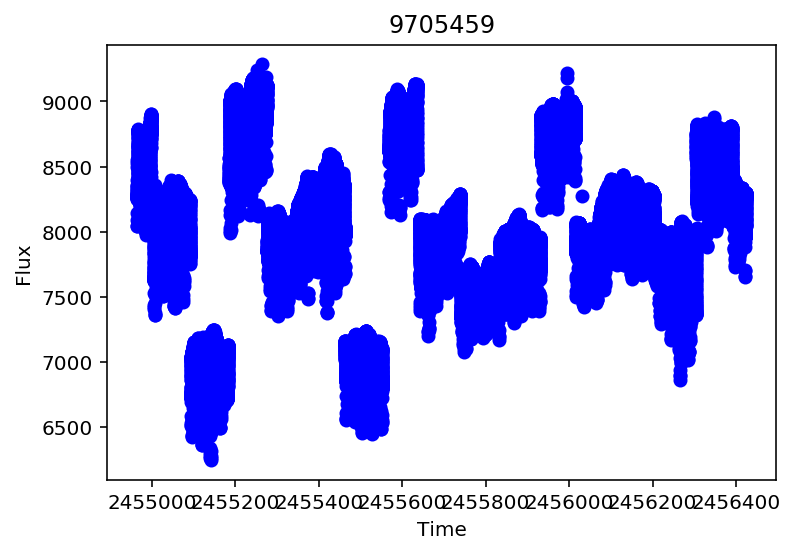

In [2]:
import h5py
hdf5_file = h5py.File("data/light_curves.hdf5", 'r')

kic_number = 9705459
lc = LightCurve.from_hdf5(hdf5_file, kic_number)

lc.plot()

In [3]:
from salter import kic_to_params

# Get transit parameters from exoplanets table
params = kic_to_params(kic_number)

In [4]:
for attr in dir(params):
    if not attr.startswith('_'):
        print("{0}: {1}".format(attr, getattr(params, attr)))

a: 8.43163572553153
b: 0.079
duration: 0.1132875
ecc: 0
fp: None
inc: 89.46316077240935
limb_dark: quadratic
per: 2.48658617
rp: 0.2052364490045567
t0: 2454967.110364
t_secondary: None
u: (0.49869999999999998, 0.1772)
w: 90


In [5]:
extra_oot_time = 2 # [durations]; Extra transit durations to keep before ingress/after egress
polynomial_order = 1

near_transit = LightCurve(**lc.mask_out_of_transit(oot_duration_fraction=extra_oot_time))
transits = near_transit.get_transit_light_curves()

for transit in transits: 
    transit.remove_polynomial_baseline(order=polynomial_order)#, plots=True)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/salter/salter/lightcurve.py:390: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:391: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:392: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the f

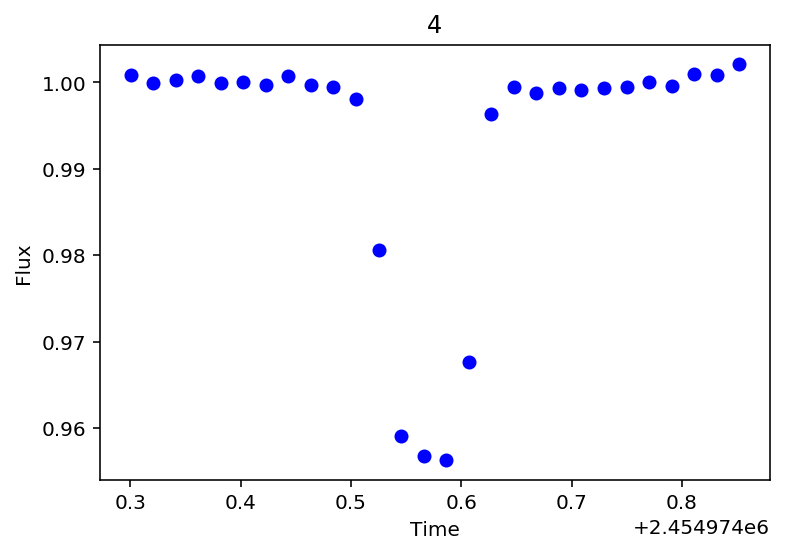

In [6]:
sample_transit = transits[4]

sample_transit.plot()

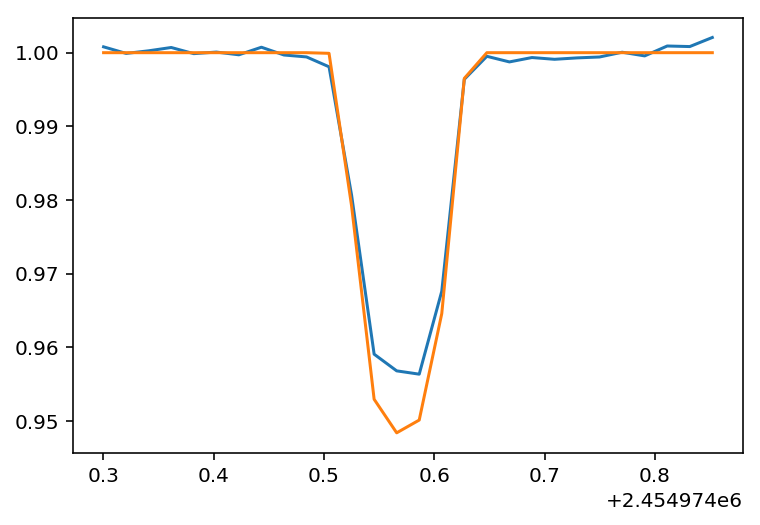

In [7]:
# Compute mandel & agol model
model = sample_transit.transit_model()

plt.plot(sample_transit.times.jd, sample_transit.fluxes)
plt.plot(sample_transit.times.jd, model)

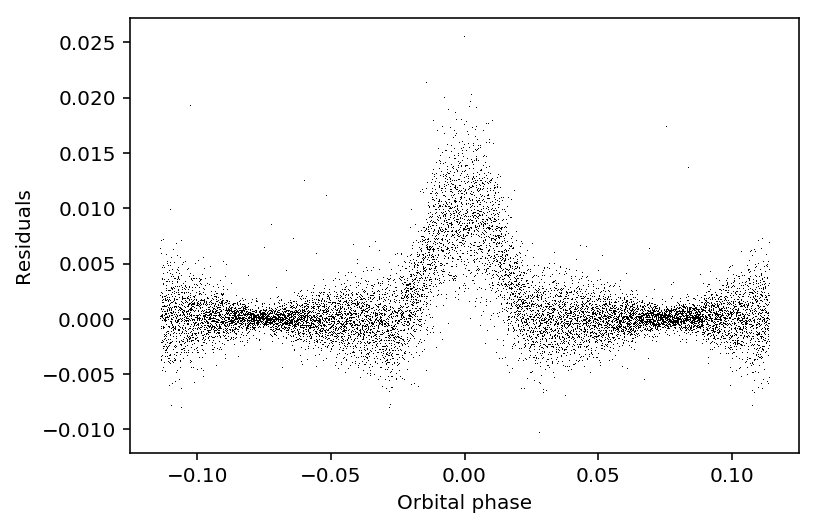

In [8]:
# plot residuals: 

for transit in transits:
    plt.plot(transit.phases(), transit.fluxes - transit.transit_model(), 'k,')
plt.xlabel('Orbital phase')
plt.ylabel('Residuals')